# Imports

In [2]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares
except:
  Exception('Error Initialising Iminuit')

In [3]:
from IPython.display import Latex
import sympy as sp
import scipy as sc
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

# Funzioni

In [4]:
def sturges(data):
  return int(1 + np.log2(len(data)))

In [5]:
def grafico(x,y,xerr,yerr, title, xlabel='x', ylabel='y', save=False):

  fig,ax = plt.subplots(1,1)

  ax.scatter(x,y, c='k')
  ax.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='None', color='k', markersize=8, capsize=5, alpha=0.5)
  # ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  if save:  plt.savefig(title+'.pdf')
  return ax

In [6]:
#function for removing Nan values from a numpy array
def rNan(arr): return arr[~np.isnan(arr)]

In [7]:
#@title Test ipotesi
def chi_test(fval, ndof, x_limit = 40):
  '''This funciton visualizes the chi2 test for a given chi2 value and degrees of freedom
  Values
  -------

    `fval` : chi2 value

    `ndof` : degrees of freedom
    `x_limit` : chi2 value limit for integral (don't change)
  '''

  x = np.linspace(0,x_limit, 1000)
  y = [sc.stats.chi2.pdf(i,df=ndof) for i in x]

  section = np.arange(fval, x_limit)
  plt.fill_between(section,sc.stats.chi2.pdf(section,df=ndof), alpha=.4)
  plt.title('Test $\chi^2$')
  plt.xlabel(r'$\chi^2$')
  plt.ylabel('$pdf(\chi^2)$')
  plt.legend([r'$\tilde\chi^2$ '+f'= {round(fval/ndof,2)} \n p-value = {round(1 - sc.stats.chi2.cdf(fval,ndof),3)*100}%'])
  plt.plot(x,y)

def t_test(tvalue, df,xlim = 7, alpha = 0.05 ):
  '''This function visualizes the t Student test for a given t value and degrees of freedom
    Values:
    -------

    `tvalue` : t Student test Value
    `df` : dergrees of freedom
    `xlim` : limit for integration (don't change)
  '''

  x = np.linspace(-xlim,xlim,2000)
  y = [ sc.stats.t.pdf(i,df) for i in x]

  section1 = np.linspace(-xlim,-tvalue)
  plt.fill_between(section1,sc.stats.t.pdf(section1,df=df), alpha=.4, color='b')

  section2 = np.linspace(tvalue, xlim)
  plt.fill_between(section2,sc.stats.t.pdf(section2,df=df), alpha=.4, color='b')

  # plt.title('t Test')
  plt.xlabel(r't')
  plt.ylabel('pdf(t)')
  plt.legend([r'$\alpha$'+f' = {round((1-sc.stats.t.cdf(tvalue,df=df))*2, 4)}'])
  plt.plot(x,y)
  return (1-sc.stats.t.cdf(tvalue,df=df))*2

In [8]:
#@title Error Propagation no Covariance

def formula_errori(parametri:str, formula:str, latex_ = False):

    #convert from str to sympy
    parametri = sp.sympify(parametri)
    formula = sp.simplify(formula)
    sigmas = sp.symbols([f'sigma_{var}' for var in parametri])
    i,exp = 0,0

    for val in parametri:

        #squared partial derivatives and sigmas
        exp += sp.diff(formula,val)**2 * sigmas[i]**2
        i+=1

    exp = sp.sqrt(exp)

    if latex_: return '$'+sp.latex(exp)+'$'

    return (exp)

def valuta_errori(formula_errori:str, values:dict, errors:dict, x:dict=None):

  #convert minuit values method to dict
  params = values.keys()

  #sustitute numerical values
  expr = formula_errori.subs(values)

  for val in errors:

    #substitute numerical for sigmas
    expr = expr.subs(f'sigma_{val}', errors[val])

  if x != None: expr = expr.subs(x)

  return expr

In [9]:
# @title media pesata
def media_pesata(x,err) -> tuple['media','sigma']:

  x_ = np.array(x)
  err_ = np.array(err)

  if x_.shape != err_.shape:
    raise Exception('Size mismatch, control arrays!')
    return

  s1,s2 = 0,0
  for i,j in zip(x_,err_):

    s1 += i/j**2
    s2 += 1/j**2

  media = s1/s2
  sigma = np.sqrt(float(1/s2))

  return media,sigma

# Dati

In [10]:
data = 'https://docs.google.com/spreadsheets/d/11Db4q9pAoPY3wLuFJ6OIKQspeL21LUiSDEYFjaHlQyw/'
df = pd.read_excel(data+'export?format=xlsx',sheet_name=None)
print(df.keys())

dict_keys(['Rv', 'Ra', 'Ra2 ', 'Ohm', 'Serie', 'Parallelo', 'Partitore', 'Diodo', 'D2'])


In [11]:
def R_parall(R1,R2):
  return (R1*R2)/(R1+R2)

# Rv

In [12]:
RV_dati = df['Rv']
# print(RV_dati)
V_rv = RV_dati['V']
I_rv = RV_dati['I [micro A]']*1e-6

In [13]:
def ohm_law(V, R):
  return V/R 
def ohm_law_trasl(V,R,l):
  return V/R + l
def ohm_law2(I,R):
  return R*I

In [14]:
c = LeastSquares(V_rv, I_rv, yerror=0.01e-6, model=ohm_law_trasl)
m = Minuit(c, R=1e6, l=1)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.329 (χ²/ndof = 0.4)      │              Nfcn = 118              │
│ EDM = 1.76e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │ 2.4683e6  │ 0.0020e6  │            │            │         │         │       │
│ 1 │ l    │  -28e-9   │   6e-9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────┐
│   │                 R                 l │
├───┼─────────────────────────────────────┤
│ R │           4.1e+06 11.95823089015e-6 │
│ l │ 11.95823089015e-6          3.94e-17 │
└───┴─────────────────────────────────────┘

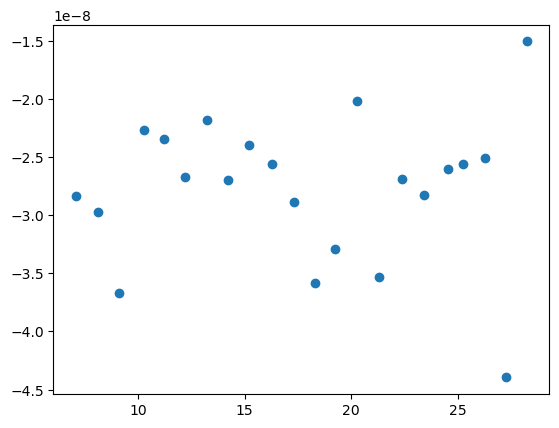

In [15]:
res = [i-j for i,j in zip(I_rv, ohm_law(V_rv, m.values['R']))]
plt.scatter(V_rv, res)

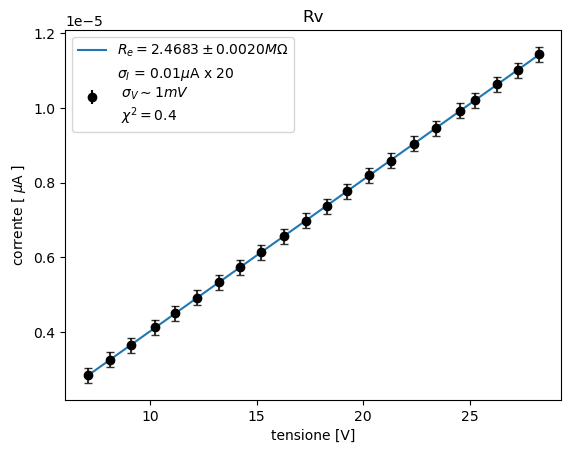

In [16]:
m.visualize()
plt.title('Rv')
plt.xlabel('tensione [V]')
plt.ylabel('corrente [ $\mu$A ]')
plt.errorbar(V_rv,I_rv,xerr=0,yerr=0.2*1e-6,linestyle='None', color='k', markersize=8, capsize=3, alpha=.8)
plt.legend([f'$R_e = {m.values["R"]*1e-6:.{4}f} \pm {m.errors["R"]*1e-6:.{4}f} M\Omega$',f'$\sigma_I$ = 0.01$\mu$A x 20 \n $\sigma_V \sim 1 mV$ \n $\chi^2 = {m.fval/m.ndof:.{1}f}$'])
plt.savefig('Rv.pdf',bbox_inches='tight')
plt.show()

In [17]:
R2 = 3.272*1e6
Req = m.values['R']

print(R2*Req/(R2-Req)/1e6 , 'M ohm')

10.049160808355111 M ohm


In [18]:
#calcolo errori su Req
def errR(V,I,sigma_V,sigma_I):
    return np.sqrt(sigma_V**2/(I**2) + (V**2*sigma_I**2)/(I**4))

# Ra

In [19]:
RA_dati = df['Ra']
# print(RA_dati)

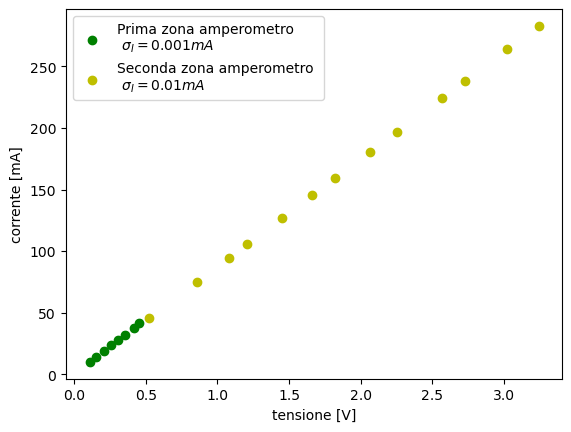

In [20]:
plt.scatter(RA_dati['V'][:8],RA_dati['I [mA]'][:8], c='g')
plt.errorbar(RA_dati['V'][:8],RA_dati['I [mA]'][:8],xerr=0.01,yerr=0.002,linestyle='None', color='g', markersize=4, capsize=3, alpha=.8)
plt.scatter(RA_dati['V'][8:],RA_dati['I [mA]'][8:],c='y')
plt.xlabel('tensione [V]')
plt.ylabel('corrente [mA]')
plt.legend(['Prima zona amperometro \n $\sigma_I = 0.001 mA$','Seconda zona amperometro \n $\sigma_I = 0.01 mA$'])
plt.savefig('RA_dati.pdf',bbox_inches='tight')

## first batch

In [117]:
c = LeastSquares(RA_dati['V'][:8], RA_dati['I [mA]'][:8]*1e-3, 0.01*1e-3, ohm_law)
m_RA_1 = Minuit(c, R=11)
m_RA_1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 215.5 (χ²/ndof = 30.8)     │              Nfcn = 16               │
│ EDM = 4.54e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  11.0159  │  0.0014   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 1.97e-06 │
└───┴──────────┘

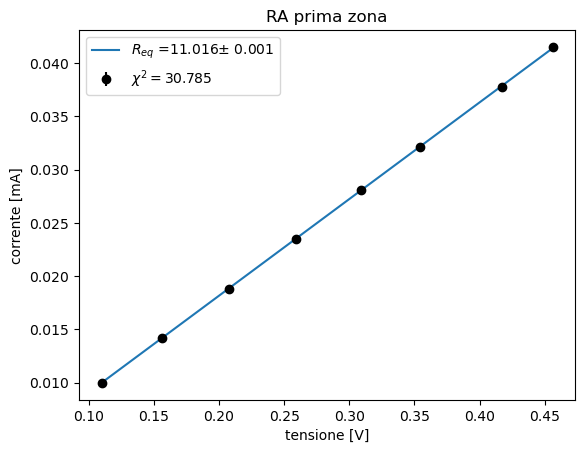

In [127]:
m_RA_1.visualize()
plt.title('RA prima zona')
plt.xlabel('tensione [V]')
plt.ylabel('corrente [mA]')
plt.legend(['$R_{eq}$ ='f'{"{:.3f}".format(m_RA_1.values["R"])}'f'$\pm$ {"{:.3f}".format(m_RA_1.errors["R"])}',
            f'$\chi^2 =${"{:.3f}".format(m_RA_1.fval/m_RA_1.ndof)}'])

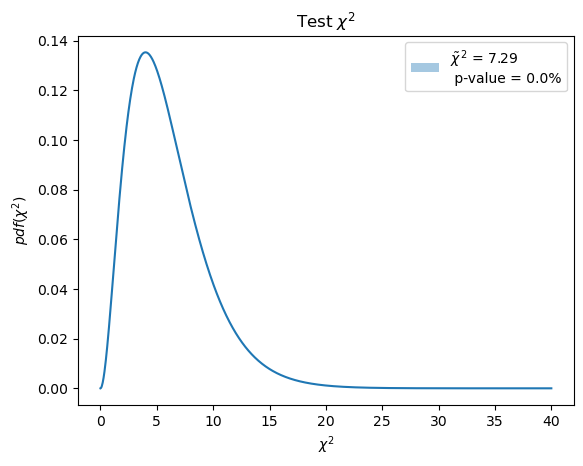

In [109]:
chi_test(m_RA_1.fval, m_RA_1.ndof)

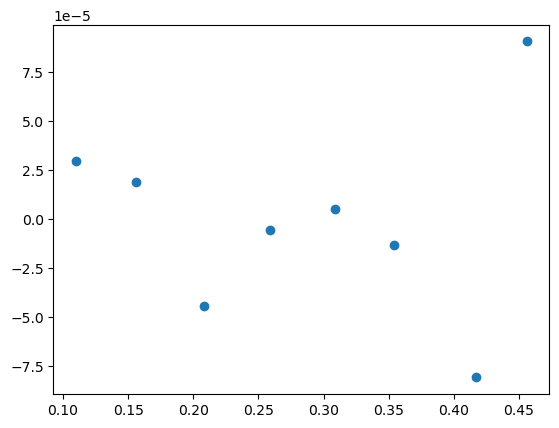

In [85]:
#resti
res_I = [i-j for i,j in zip(RA_dati['I [mA]'][:8]*1e-3, ohm_law_trasl(RA_dati['V'][:8],m_RA_1.values['R'], l=m_RA_1.values['l']))]
plt.scatter(RA_dati['V'][:8],res_I)

## Second Batch

### Con Shift

In [23]:
c = LeastSquares(RA_dati['V'][8:], RA_dati['I [mA]'][8:], RA_dati['err I [mA]'][8:]*10, ohm_law_trasl)
m_RA_2 = Minuit(c, R=11e-3, l=0)
m_RA_2.fixed['l'] = False
m_RA_2.migrad()
m_RA_2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.02 (χ²/ndof = 8.0)      │              Nfcn = 54               │
│ EDM = 1.38e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │11.4514e-3 │ 0.0024e-3 │            │            │         │         │       │
│ 1 │ l    │   0.084   │   0.016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         R         l │
├───┼─────────────────────┤
│ R │  5.74e-12 29.821e-9 │
│ l │ 29.821e-9  0.000244 │
└───┴─────────────────────┘

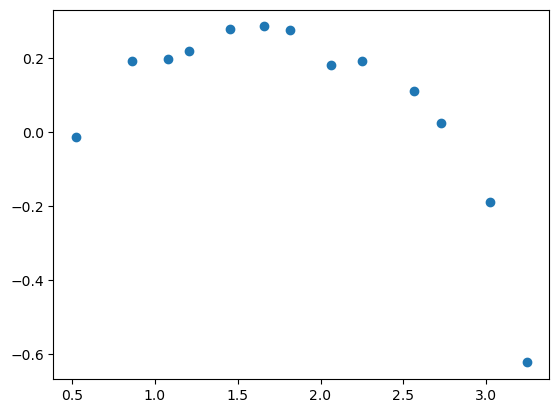

In [24]:
res = [i-j for i,j in zip(RA_dati['I [mA]'][8:], ohm_law_trasl(RA_dati['V'][8:], m_RA_2.values['R'], m_RA_2.values['l']))]
plt.scatter(RA_dati['V'][8:], res)

### Senza Shift

In [25]:
c = LeastSquares(RA_dati['V'][8:], RA_dati['I [mA]'][8:], RA_dati['err I [mA]'][8:]*10, ohm_law)
m_RA_2 = Minuit(c, R=11e-3)
m_RA_2.migrad()
m_RA_2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 117 (χ²/ndof = 9.7)        │              Nfcn = 28               │
│ EDM = 2.22e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │11.4412e-3 │ 0.0014e-3 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 2.09e-12 │
└───┴──────────┘

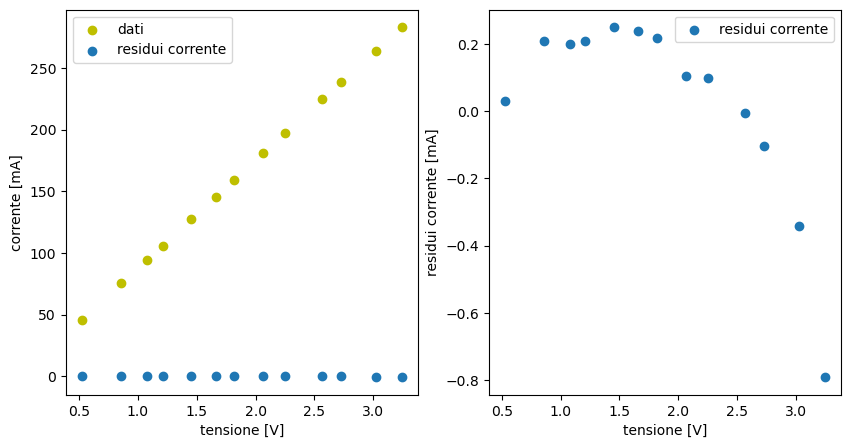

In [26]:
res_I = [i-j for i,j in zip(RA_dati['I [mA]'][8:], ohm_law(RA_dati['V'][8:], m_RA_2.values['R']))]
plt.subplots(1,2,figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(RA_dati['V'][8:],RA_dati['I [mA]'][8:],c='y')
plt.scatter(RA_dati['V'][8:],res_I)
plt.legend(['dati','residui corrente'])
plt.xlabel('tensione [V]')
plt.ylabel('corrente [mA]')

plt.subplot(1,2,2)
plt.scatter(RA_dati['V'][8:],res_I)
plt.legend(['residui corrente'])
plt.ylabel('residui corrente [mA]')
plt.xlabel('tensione [V]')

plt.savefig('RA_res_I.pdf',bbox_inches='tight')

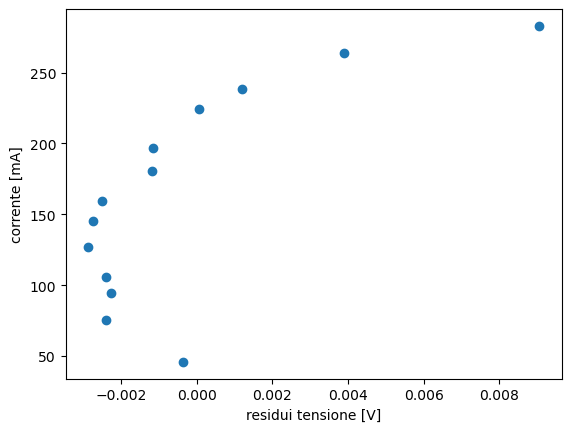

In [27]:
res_V = [i-j for i,j in zip(RA_dati['V'][8:], ohm_law2(RA_dati['I [mA]'][8:],m_RA_2.values['R']))]
plt.scatter(res_V, RA_dati['I [mA]'][8:])
plt.ylabel('corrente [mA]')
plt.xlabel('residui tensione [V]')
plt.savefig('RA_res_V.pdf',bbox_inches='tight')

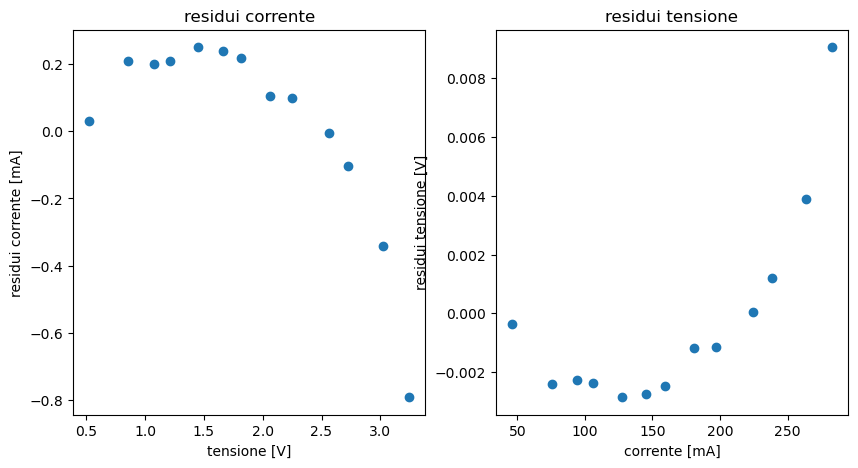

In [28]:
plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.title('residui corrente')
plt.scatter(RA_dati['V'][8:], res_I)
plt.xlabel('tensione [V]')
plt.ylabel('residui corrente [mA]')

plt.subplot(1,2,2)
plt.title('residui tensione')
plt.scatter( RA_dati['I [mA]'][8:], res_V)
plt.ylabel('residui tensione [V]')
plt.xlabel('corrente [mA]')
plt.savefig('RA_res_both.pdf',bbox_inches='tight')

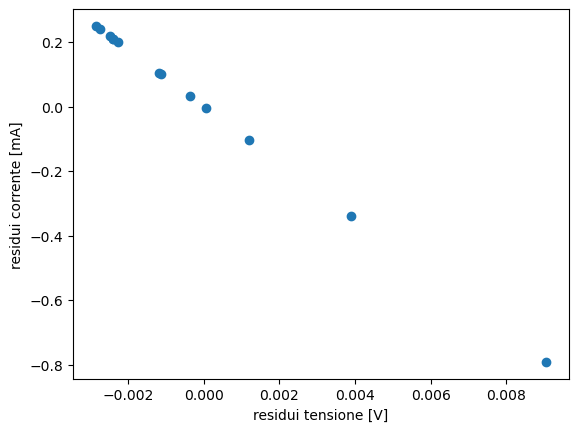

In [29]:
plt.xlabel('residui tensione [V]')
plt.ylabel('residui corrente [mA]')
plt.savefig('RA_res.pdf',bbox_inches='tight')
plt.scatter(res_V, res_I)
# plt.scatter(RA_dati['V'][:8],RA_dati['I [mA]'][:8], c='g')

In [30]:
def linear(x,m,q):
    return m*x + q

In [31]:
c = LeastSquares(np.array(res_V), np.array(res_I), .01, linear)
m_RA_res = Minuit(c, m=1, q=1) 
m_RA_res.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.772e-06 (χ²/ndof = 0.0)  │              Nfcn = 38               │
│ EDM = 1.77e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   -87.4   │    0.8    │            │            │         │         │       │
│ 1 │ q    │  -0.0000  │  0.0028   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        m        q │
├───┼───────────────────┤
│ m │    0.718   202e-6 │
│ q │   202e-6 7.75e-06 │
└───┴───────────────────┘

In [32]:
print((1/m_RA_res.values['m'])*1e3)

-11.441211219278117


# Legge Ohm


In [33]:
Ohm = df['Ohm']
print(Ohm.keys())

Index(['Resistenza kΩ', 'Unnamed: 1', 'V 1', 'Ι [μA] 1', 'Unnamed: 4', 'V 2',
       'I [μA] 2', 'Unnamed: 7'],
      dtype='object')


## Configurazione 1

In [34]:
c = LeastSquares(Ohm['V 1'], Ohm['Ι [μA] 1']*1e-6, 0.015e-6, ohm_law)
m1 = Minuit(c, R=2)
m1.migrad()
m1.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.41 (χ²/ndof = 1.0)      │              Nfcn = 153              │
│ EDM = 1.43e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │ 147.454e3 │  0.028e3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────┐
│   │   R │
├───┼─────┤
│ R │ 814 │
└───┴─────┘

In [35]:
R_V = 3.272e6
R = m1.values['R']*R_V/(R_V-m1.values['R'])
print(R/1e3)

154.4122971878442


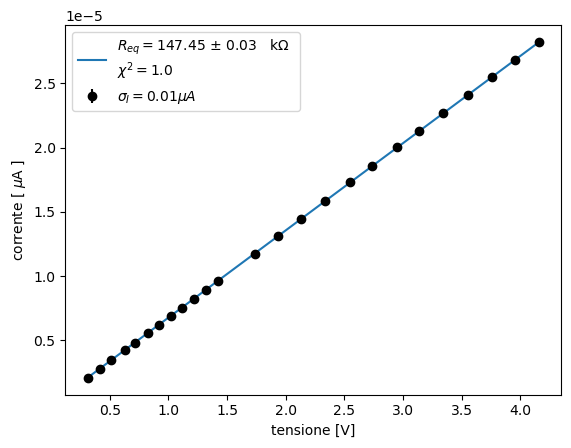

In [36]:
m1.visualize()
plt.xlabel('tensione [V]')
plt.ylabel('corrente [ $\mu$A ]')
plt.legend(['$R_{eq} = $'f'{"{:.2f}".format(m1.values["R"]*1e-3)} $\pm$ {"{:.2f}".format(m1.errors["R"]*1e-3)}   k$\Omega$  \n$\chi^2 = $'f'{"{:.1f}".format(m1.fval/m1.ndof)}'
            ,'$\sigma_{I} = 0.01 \mu A$'])
plt.savefig('Ohm_conf2.pdf',bbox_inches='tight')

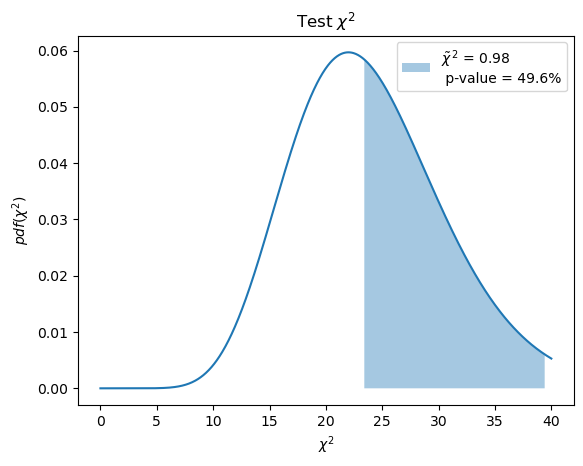

In [37]:
chi_test(m1.fval, m1.ndof)
plt.savefig('Ohm_c1_chi2.pdf',bbox_inches='tight')

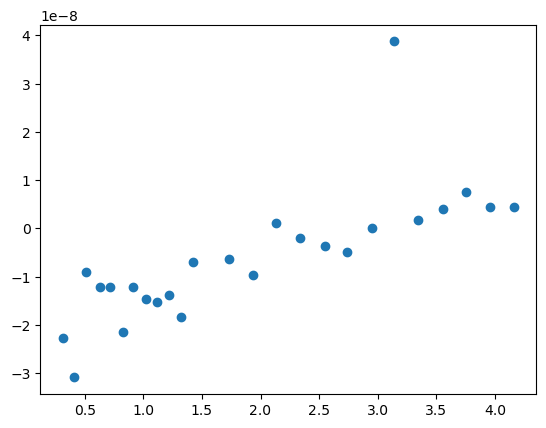

In [38]:
#residui
res_I = [i-j for i,j in zip(Ohm['Ι [μA] 1']*1e-6, ohm_law(Ohm['V 1'],m1.values['R']))]
plt.scatter(Ohm['V 1'],res_I)

1.6975472297866785


0.10200943214164648

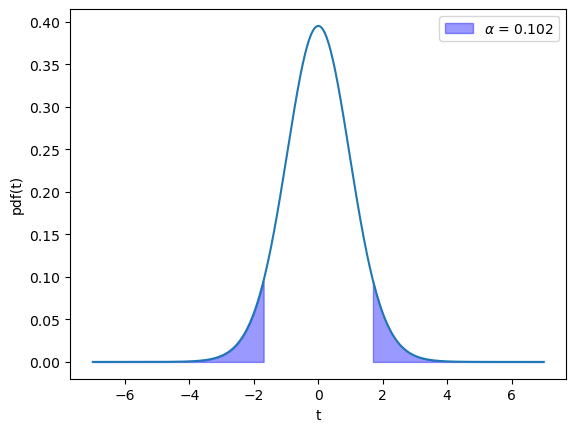

In [39]:
t1 = abs(m1.values['R']-150e3)/(np.sqrt(m1.errors['R']**2 + (150e3*0.05)**2 )/np.sqrt(25))
print(t1)
t_test(t1, 25)

## Configurazione 2

In [131]:
c = LeastSquares(Ohm['V 2'], Ohm['I [μA] 2']*1e-6, 0.01*1e-6, ohm_law)
m = Minuit(c, R=150e3)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.06 (χ²/ndof = 0.8)      │              Nfcn = 23               │
│ EDM = 1e-05 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │ 149.519e3 │  0.014e3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────┐
│   │   R │
├───┼─────┤
│ R │ 206 │
└───┴─────┘

In [133]:
np.sqrt(m.errors['R']**2 + (0.01)**2)

14.34136373741635

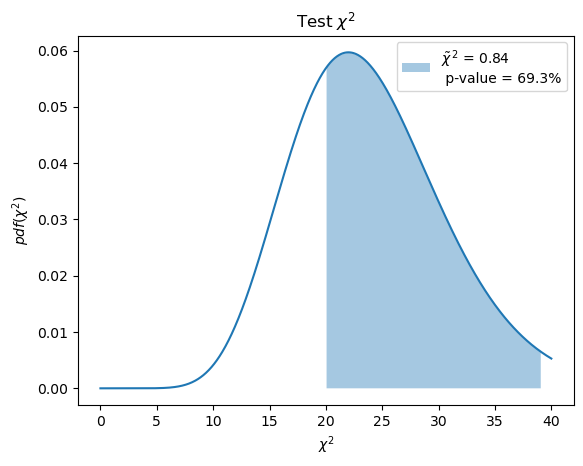

In [41]:
chi_test(m.fval, m.ndof)
plt.savefig('Ohm_c2_chi_test.pdf',bbox_inches='tight')

In [42]:
def sn(val,n=2):
    return ("{:."+f'{n}'+"e}").format(val)

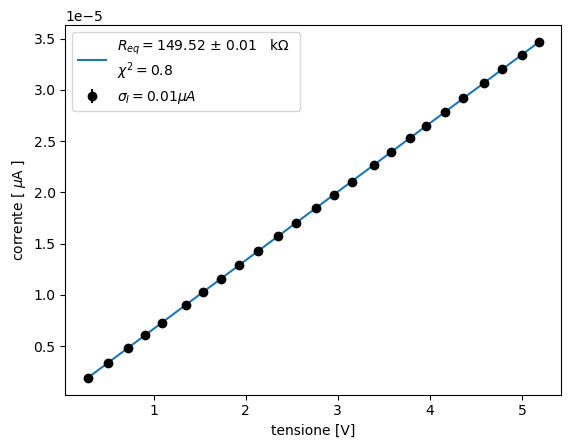

In [43]:
m.visualize()
plt.xlabel('tensione [V]')
plt.ylabel('corrente [ $\mu$A ]')
plt.legend(['$R_{eq} = $'f'{"{:.2f}".format(m.values["R"]*1e-3)} $\pm$ {"{:.2f}".format(m.errors["R"]*1e-3)}   k$\Omega$  \n$\chi^2 = $'f'{"{:.1f}".format(m.fval/m.ndof)}'
            ,'$\sigma_{I} = 0.01 \mu A$'])
plt.savefig('Ohm_conf2.pdf',bbox_inches='tight')

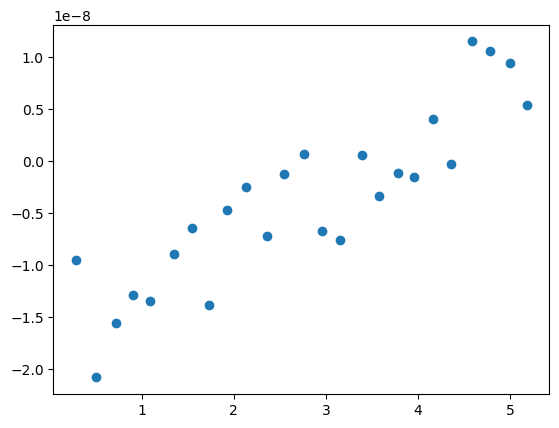

In [44]:
#residui 
res_I = [i-j for i,j in zip(Ohm['I [μA] 2']*1e-6, ohm_law(Ohm['V 2'],m.values['R']))]
plt.scatter(Ohm['V 2'],res_I)

In [45]:
print(len(c.data))

25


0.3208957011487476


0.750956597313031

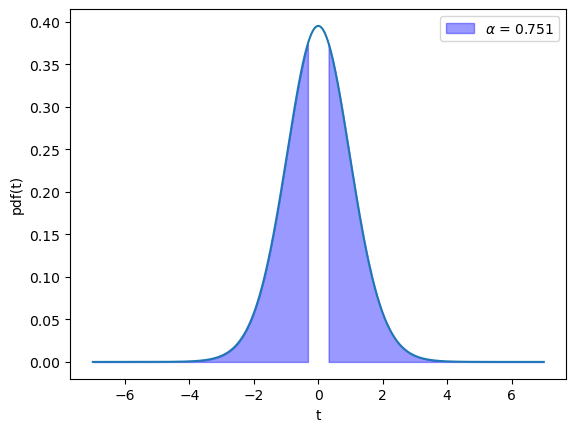

In [46]:
t = abs(m.values['R']-150e3)/(np.sqrt(m.errors['R']**2 + (150e3*0.05)**2 )/np.sqrt(25))
print(t)
t_test(t, 25)

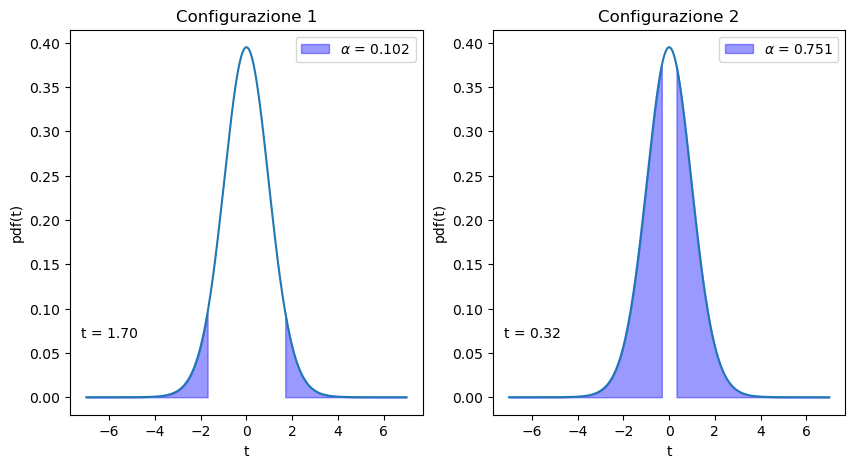

In [47]:
plt.subplots(1,2,figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Configurazione 1')
t_test(t1, 25)
plt.text(0.03,.2,f't = {"{:.2f}".format(t1)}',transform=plt.gca().transAxes)

plt.subplot(1,2,2)
plt.title('Configurazione 2')
plt.text(0.03,.2,f't = {"{:.2f}".format(t)}',transform=plt.gca().transAxes)
t_test(t, 25)
plt.savefig('Ohm_t_test.pdf',bbox_inches='tight')

# R Serie

In [48]:
R_serie = df['Serie']

In [128]:
c = LeastSquares(R_serie['V'], R_serie['I']*1e-6, .01*1e-6, ohm_law)
m = Minuit(c, R=2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.09 (χ²/ndof = 0.6)      │              Nfcn = 155              │
│ EDM = 4.44e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │ 298.78e3  │  0.08e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 6.51e+03 │
└───┴──────────┘

# R //

In [50]:
R_par = df['Parallelo']

In [129]:
c = LeastSquares(R_par['V'], R_par['I']*1e-6, .01*1e-6, ohm_law)
m = Minuit(c, R=2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1325 (χ²/ndof = 69.7)      │              Nfcn = 141              │
│ EDM = 1.15e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │ 74.722e3  │  0.005e3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────┐
│   │    R │
├───┼──────┤
│ R │ 24.3 │
└───┴──────┘

# Partitore


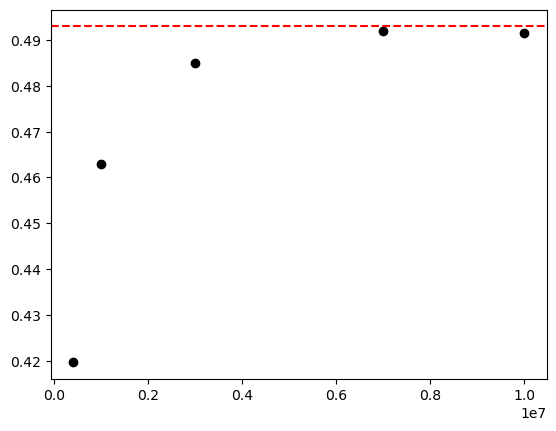

In [52]:
part_dati = df['Partitore']
plt.axhline(y=0.493, color='r', linestyle='--')
plt.scatter(rNan(part_dati['R']),rNan(part_dati['pendenza']), c='k')

In [53]:
def foo(x,a):
    return a*np.log(x)

In [54]:
V1 = rNan(part_dati['V in 1'])
V_1 = rNan(part_dati['V out [mV] 1'])

V2 = rNan(part_dati['V in 2'])
V_2 = rNan(part_dati['V out [mV] 2'])

V3 = rNan(part_dati['V in 3'])
V_3 = rNan(part_dati['V out [mV] 3'])

V4 = rNan(part_dati['V in 4'])
V_4 = rNan(part_dati['V out [mV] 4'])

V5 = rNan(part_dati['V in 5'])
V_5 = rNan(part_dati['V out [mV] 5'])

In [55]:
c = LeastSquares(V1, V_1, .2, linear)
m1 = Minuit(c, m=1, q=0)
m1.migrad()
m1.hesse()
plt.close()

c = LeastSquares(V2, V_2, 0.2, linear)
m2 = Minuit(c, m=1, q=0)
m2.migrad()
m2.hesse()
plt.close()

c = LeastSquares(V3, V_3, 0.2, linear)
m3 = Minuit(c, m=1, q=0)
m3.migrad()
m3.hesse()
plt.close()

c = LeastSquares(V4, V_4, 0.2, linear)
m4 = Minuit(c, m=1, q=0)
m4.migrad()
m4.hesse()
plt.close()

c = LeastSquares(V5, V_5, 0.2, linear)
m5 = Minuit(c, m=1, q=0)
m5.migrad()
m5.hesse()
plt.close()

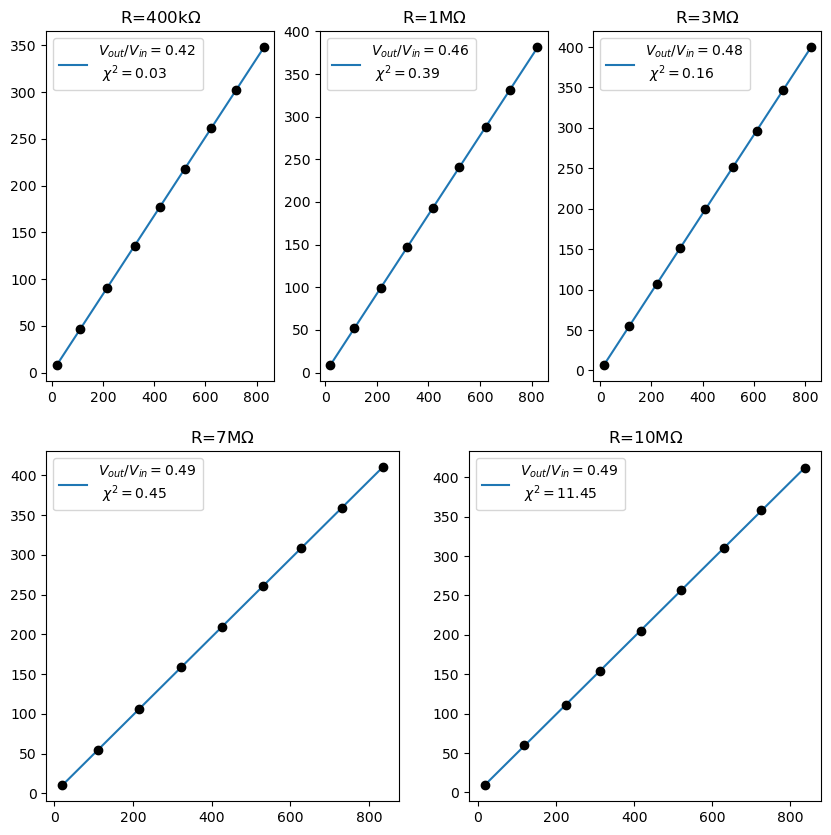

In [56]:
f = plt.figure(figsize=(10,10))

plt.subplot(2,3,1)
plt.title('R=400k$\Omega$')
m1.visualize()
plt.legend(['$V_{out}/V_{in} =$'f'{"{:.2f}".format(m1.values["m"])} \n $\chi^2 =$'f'{"{:.2f}".format(m1.fval/m1.ndof)}'])

plt.subplot(2,3,2)
plt.title('R=1M$\Omega$')
m2.visualize()
plt.legend(['$V_{out}/V_{in} =$'f'{"{:.2f}".format(m2.values["m"])} \n $\chi^2 =$'f'{"{:.2f}".format(m2.fval/m2.ndof)}'])

plt.subplot(2,3,3)
plt.title('R=3M$\Omega$')
m3.visualize()
plt.legend(['$V_{out}/V_{in} =$'f'{"{:.2f}".format(m3.values["m"])} \n $\chi^2 =$'f'{"{:.2f}".format(m3.fval/m3.ndof)}'])


plt.subplot(2,2,3)
plt.title('R=7M$\Omega$')
m4.visualize()
plt.legend(['$V_{out}/V_{in} =$'f'{"{:.2f}".format(m4.values["m"])} \n $\chi^2 =$'f'{"{:.2f}".format(m4.fval/m4.ndof)}'])

plt.subplot(2,2,4)
plt.title('R=10M$\Omega$')
m5.visualize()
plt.legend(['$V_{out}/V_{in} =$'f'{"{:.2f}".format(m5.values["m"])} \n ''$\chi^2 =$'f'{"{:.2f}".format(m5.fval/m5.ndof)}'])

plt.savefig('Partitore_fit.pdf')

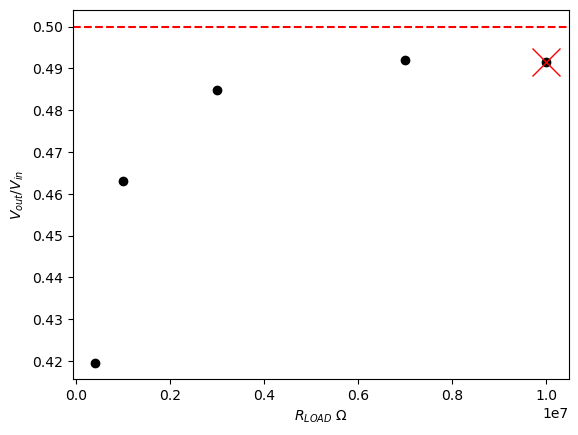

In [57]:
ms = [m1.values['m'], m2.values['m'], m3.values['m'], m4.values['m'], m5.values['m']]
plt.axhline(y=0.5, color='r', linestyle='--')
plt.scatter(rNan(part_dati['R']), ms, c='k')
# plt.scatter(rNan(part_dati['R']),rNan(part_dati['pendenza']), c='k')
plt.xlabel('$R_{LOAD}$ $\Omega$')
plt.ylabel('$V_{out}/V_{in}$')
plt.plot(rNan(part_dati['R'])[4:], ms[4:], marker='x', markersize=20, c='r')
plt.savefig('Partitore.pdf')
plt.show()

# Diodo 

In [58]:
Diodo = df['Diodo']
print(Diodo.keys())

Index(['diodo IN4006', 'V 1', 'I [mA] 1', 'Unnamed: 3', 'Unnamed: 4', 'V 2',
       'I [mA] 2'],
      dtype='object')


In [59]:
V1_diodo = rNan(Diodo['V 1'])
I1_diodo = rNan(Diodo['I [mA] 1'])

V2_diodo = rNan(Diodo['V 2'])
I2_diodo = rNan(Diodo['I [mA] 2'])

In [60]:
def linear(x,a,c):
    return a*x+c

In [61]:
diodo_1_rid = [],[]
for i,j in zip(np.array(V1_diodo),np.array(I1_diodo)):
    tmp = np.log(j)
    if np.isnan(tmp):
        continue
    elif tmp == -np.inf:
        continue
    else:
        diodo_1_rid[0].append(i)
        diodo_1_rid[1].append(tmp)


diodo_1_rid = np.array(diodo_1_rid)

/tmp/ipykernel_10159/1633179446.py:3: RuntimeWarning: divide by zero encountered in log
  tmp = np.log(j)


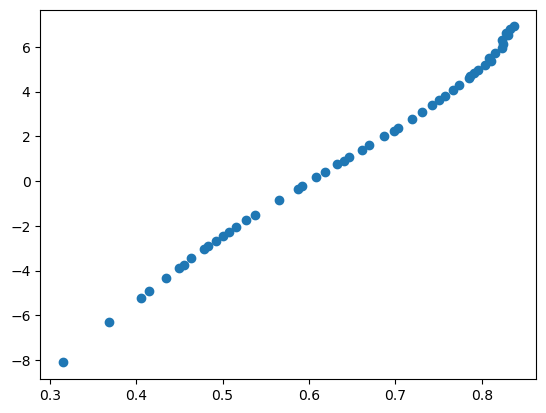

In [62]:
plt.scatter(diodo_1_rid[0], diodo_1_rid[1])

In [63]:
v = 0
i = 3
while v < 1:
    c = LeastSquares(diodo_1_rid[0][:i], diodo_1_rid[1][:i], np.log(1.1), linear)
    m = Minuit(c, a=1, c=0)
    m.migrad()
    v = m.fval/m.ndof
    i+=1
print(i)
m.migrad()

18


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.74 (χ²/ndof = 1.3)      │              Nfcn = 48               │
│ EDM = 8.87e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   29.0    │    0.4    │            │            │         │         │       │
│ 1 │ c    │  -17.02   │   0.17    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────┐
│   │      a      c │
├───┼───────────────┤
│ a │   0.14 -0.065 │
│ c │ -0.065 0.0308 │
└───┴───────────────┘

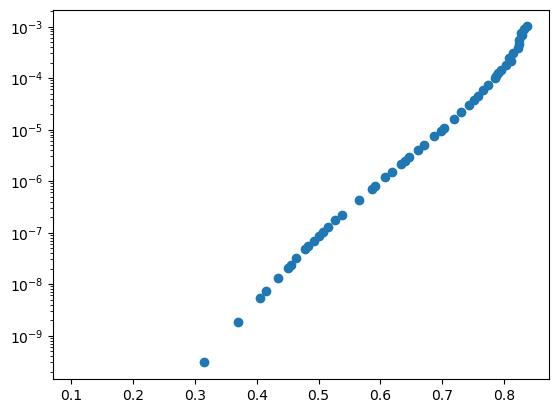

In [64]:
plt.scatter(Diodo['V 1'], Diodo['I [mA] 1']*1e-6)
plt.yscale('log')

In [65]:
def shockley(Io, V):
  g = 1e-3
  q = 1.6e19
  k = 1.38e23
  T = 300

  return Io*(np.exp(V*q/(g*k*T))-1)

# Diodo 2


In [66]:
D2 = df['D2']

In [67]:
def shockley(V,Io,g=3):
  
  q = 1.602e-19
  k = 1.38e-23
  T = 300

  return Io*(np.exp(V*q/(g*k*T))-1)

In [68]:
chi = 0
val1,val2 = 0,4
while chi<1:
    
    val2 +=1
    c = LeastSquares(D2['V [mV] 1'][val1:val2], D2['I [mA] 1'][val1:val2], D2['err A 1'][val1:val2]*1e1, shockley)
    m = Minuit(c, Io=1, g=1)
    m.migrad()
    chi = m.fval/m.ndof
print(val2)
print('Tensione limite: ',D2['V [mV] 1'][val2-1])
m.migrad()


27
Tensione limite:  0.761


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.28 (χ²/ndof = 0.8)      │              Nfcn = 711              │
│ EDM = 3.08e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Io   │  1.2e-6   │  0.5e-6   │            │            │         │         │       │
│ 1 │ g    │   1.75    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────┐
│    │          Io           g │
├────┼─────────────────────────┤
│ Io │    2.46e-13 22.68166e-9 │
│  g │ 22.68166e-9      0.0021 │
└────┴─────────────────────────┘

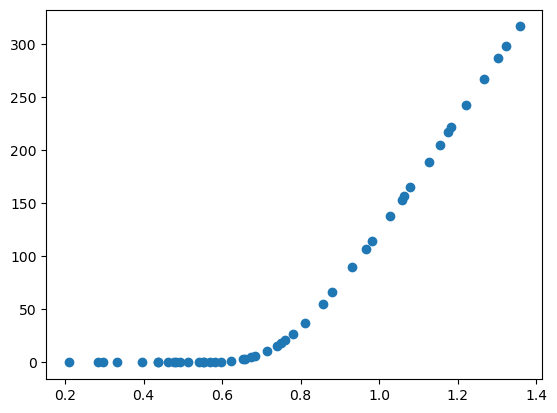

In [69]:
plt.scatter(D2['V [mV] 1'],D2['I [mA] 1'])

In [70]:
def linear(x,a,b): return a*x + b

In [71]:
V = rNan(D2['V [mV] 1'].to_numpy())
I = rNan(D2['I [mA] 1'].to_numpy())
I_err = rNan(D2['err A 1'].to_numpy())

var = len(V)-5

c = LeastSquares(V[var:],I[var:],I_err[var:]*1e2,linear)
m = Minuit(c, a=1, b=0)

m.migrad()
chi = m.fval/m.ndof
m.hesse()


while(chi<1):
    c = LeastSquares(V[var:],I[var:], np.ones(len(I_err[var:])) ,linear)
    m = Minuit(c, a=542.01, b=-419.78)
    m.migrad()
    m.hesse()
    chi = m.fval/m.ndof
    var -= 1

print(f'$\chi^2 =$ {chi}')
m.migrad()

$\chi^2 =$ 1.4013557078898824


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.62 (χ²/ndof = 1.4)      │              Nfcn = 59               │
│ EDM = 3.35e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   535.7   │    2.0    │            │            │         │         │       │
│ 1 │ b    │  -412.3   │    2.2    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────┐
│   │    a    b │
├───┼───────────┤
│ a │ 3.83   -4 │
│ b │   -4 5.03 │
└───┴───────────┘

<IPython.core.display.Latex object>

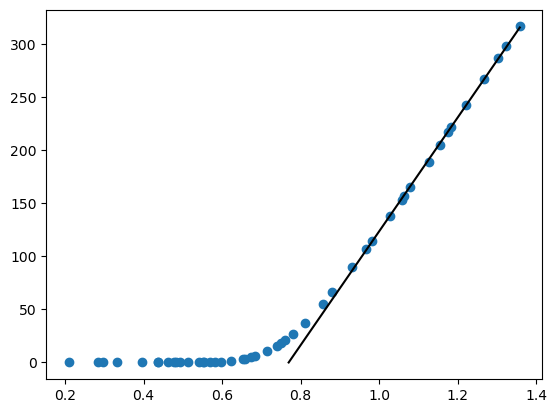

In [72]:
plt.scatter(V,I)
f = -m.values['b']/m.values['a']
x = np.linspace(f,np.max(V))
y = [linear(i,m.values['a'], m.values['b']) for i in x]
plt.plot(x,y, c='k')
Latex(f'$V_s$ = {f} V')